#### Описание задачи

### Компании заинтересованы в ответах на два вопроса:

Будет ли кампания успешной?
Если кампания была успешной, насколько этот успех можно объяснить рекламой?
Чтобы ответить на второй вопрос, мы обычно проводим A/B тестирование.

Большинство людей будут видеть рекламу (экспериментальная группа). А небольшая часть людей (контрольная группа) вместо этого увидит объявление государственной службы (PSA) (или ничего) точно такого же размера и в том же месте, где обычно находится реклама.

Идея задания состоит в том, чтобы проанализировать группы, выяснить, была ли реклама успешной, сколько компания может заработать на рекламе и является ли разница между группами статистически значимой.

### Словарь данных:

- user id: Идентификатор пользователя (уникальный).
- test group: Если "ad", то человек видел рекламу, если "psa", то он видел только объявление государственной службы.
- converted: Если человек купил продукт, то True, иначе False.
- total ads: Количество рекламы, увиденной человеком.
- most ads day: День, в который человек увидел наибольшее количество рекламы.
- most ads hour: Час дня, в который человек увидел наибольшее количество рекламы.

### Проанализируйте структуру данных и проведите их предобработку

- Исследуйте структуру данных;
- Преобразуйте столбцы к необходимым типам данных.
- Проверьте данные на наличие пропусков и избавьтесь от них, если нужно.
- Проверьте, есть ли пользователи, которые в процессе A/Bтеста попали в обе группы. Если да, исключите пользователей,оказавшихся в обеих группах.

In [407]:
# Импорт необходимых библиотек
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

from scipy.stats import mannwhitneyu
from scipy.stats import shapiro, kstest
import seaborn as sns

import statsmodels.api as sm

from statsmodels.stats.proportion import proportions_ztest, proportion_confint

from scipy.stats import norm



In [408]:
# Загрузка данных 
dataset = pd.read_csv('data.csv')


##### Исследование и обработка данных 

In [409]:
# Вывод первых 10 строк
dataset.head(10)


,Unnamed: 0,user id,test group,converted,total ads,most ads day,most ads hour
0,0,1069124,ad,False,130,Monday,20
1,1,1119715,ad,False,93,Tuesday,22
2,2,1144181,ad,False,21,Tuesday,18
3,3,1435133,ad,False,355,Tuesday,10
4,4,1015700,ad,False,276,Friday,14
5,5,1137664,ad,False,734,Saturday,10
6,6,1116205,ad,False,264,Wednesday,13
7,7,1496843,ad,False,17,Sunday,18
8,8,1448851,ad,False,21,Tuesday,19
9,9,1446284,ad,False,142,Monday,14


In [410]:
# Исследуем данные на наличие пропусков
dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 588101 entries, 0 to 588100
Data columns (total 7 columns):
 #   Column         Non-Null Count   Dtype 
---  ------         --------------   ----- 
 0   Unnamed: 0     588101 non-null  int64 
 1   user id        588101 non-null  int64 
 2   test group     588101 non-null  object
 3   converted      588101 non-null  bool  
 4   total ads      588101 non-null  int64 
 5   most ads day   588101 non-null  object
 6   most ads hour  588101 non-null  int64 
dtypes: bool(1), int64(4), object(2)
memory usage: 27.5+ MB


Исследование показывает, что в данных отсутсвуют пропуски

In [411]:
## Учитывая описание исследуемого датасета, можем удалить столбцы: "Unnamed: 0", "User id", 
# так как данные, содержащиеся в них не являются информативными.

dataset = dataset.drop(['Unnamed: 0'], axis=1)

# Проверяем, что удаление произошло корректно
dataset.head()



,user id,test group,converted,total ads,most ads day,most ads hour
0,1069124,ad,False,130,Monday,20
1,1119715,ad,False,93,Tuesday,22
2,1144181,ad,False,21,Tuesday,18
3,1435133,ad,False,355,Tuesday,10
4,1015700,ad,False,276,Friday,14


#### Задание : 
Проверьте, есть ли пользователи, которые в процессе A/Bтеста попали в обе группы. Если да, исключите пользователей, оказавшихся в обеих группах.

В целях установить наличие пользователей, которые могли попасть в обе группы, отобранных для тестирования, следует првоерить столбцы user id, test group.

In [412]:
## Проверка данных в столбце "test group" на наличие уникальных записей
dataset['test group'].unique()

array(['ad', 'psa'], dtype=object)

In [413]:
dataset['test group'].value_counts()

test group
ad     564577
psa     23524
Name: count, dtype: int64

In [414]:
duplicates_mask = dataset['user id'].duplicated()
duplicates = dataset[duplicates_mask]
print("\nСтроки с повтроами:")
print(duplicates)




Строки с повтроами:
Empty DataFrame
Columns: [user id, test group, converted, total ads, most ads day, most ads hour]
Index: []


Как видно в стоблце test group имеются только две категории: "ad", "psa". Следует отметить, что отсутствуют записи, объединяющие в себе одновременно обе категории. Исследованием столбца "user id" уставлено, что в нем нет значний указазанных дважды. Таким образом, можно сделать вывод о том, что в приведенных данных нет пользователей, которые относятся к обеим категориям.

In [415]:
## Удаление столбца "user id", котороый не несет значимой информации
dataset = dataset.drop(['user id'], axis=1)
dataset.head()


,test group,converted,total ads,most ads day,most ads hour
0,ad,False,130,Monday,20
1,ad,False,93,Tuesday,22
2,ad,False,21,Tuesday,18
3,ad,False,355,Tuesday,10
4,ad,False,276,Friday,14


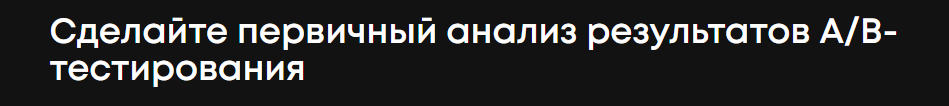

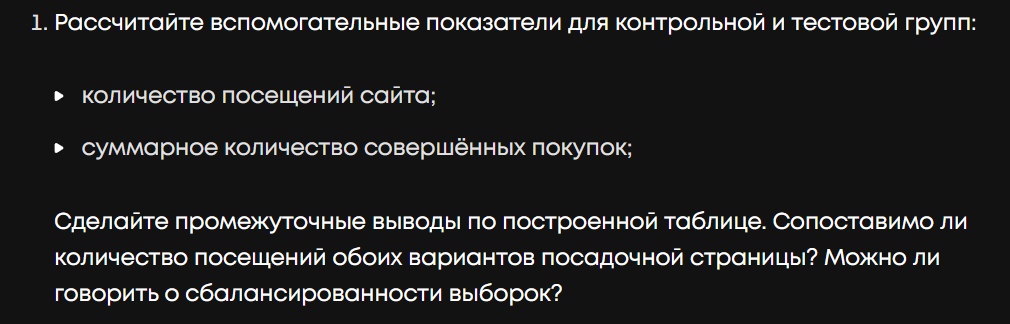

### Решение: 
Так как в качестве датасета дана статистика посещения сайта (одна на прмяу это в задании не сказано), то количество посещений сайта определим как 588 101 (количество уникальных пользователелей)

In [416]:
## Находим сумарное количество совершенных покупок
dataset['converted'].value_counts()


converted
False    573258
True      14843
Name: count, dtype: int64

Количество совершенных покупок : 14 843

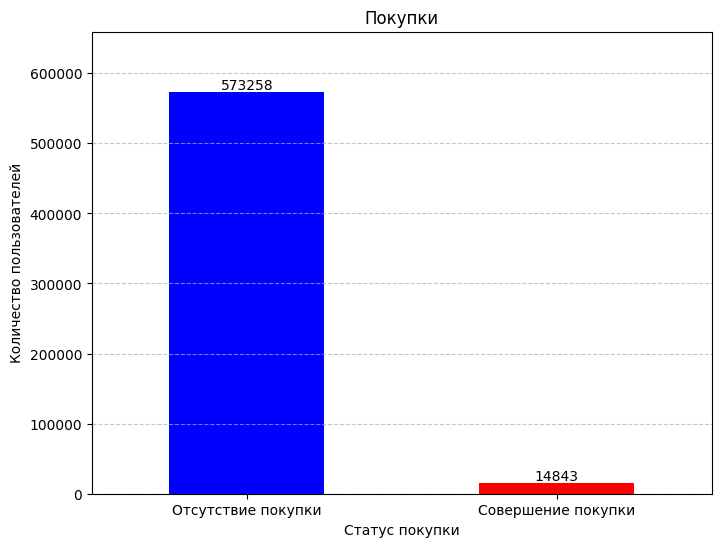

In [417]:
## Построение графика для каждой из категорий 

converted_counts = dataset['converted'].value_counts()
converted_counts.index = converted_counts.index.map({True: 'Совершение покупки', False: 'Отсутствие покупки'})


plt.figure(figsize=(8, 6))
ax = converted_counts.plot(kind='bar', color=['blue', 'red'])

# Подписей значений
for p in ax.patches:
    ax.annotate(
        f'{p.get_height()}',
        (p.get_x() + p.get_width() / 2., p.get_height()),
        ha='center',
        va='center',
        xytext=(0, 5),
        textcoords='offset points'
    )

# Настройка отображения
plt.title('Покупки')
plt.xlabel('Статус покупки')
plt.ylabel('Количество пользователей')
plt.xticks(rotation=0)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.ylim(0, converted_counts.max() * 1.15)  # Отступ сверху для подписей

plt.show()

In [418]:
print('Процент пользователей, которые не совершили покупу:', round((573258/588101*100),2))
print('Процент пользователей, которые совершили покупу:', round((14843/588101*100),2))



Процент пользователей, которые не совершили покупу: 97.48
Процент пользователей, которые совершили покупу: 2.52


### Вывод:
Из графика видно, что количество пользователей, не совершивших покупку составило: 573 258 (97.4% от общего числа пользователе ); 
пользователей, совершивших покупку совершивших покупку 14 843 (2.52% от общего числа пользователей). Таким образом, выборки двух категорий пользователей не сбалансирована.

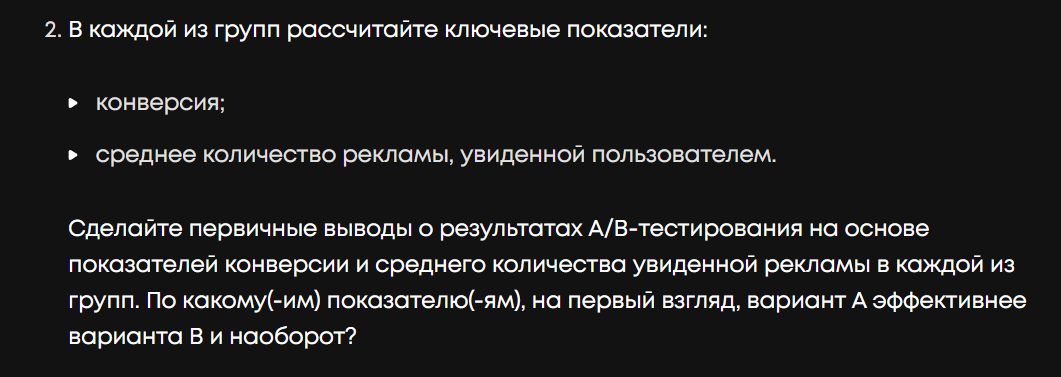

In [419]:
## Исследуем конверсию для группы пользователей "psa" (пользователи, которые не видели рекламу),

filtered_dataset = dataset[(dataset['test group'] == 'psa') & (dataset['converted'] == True)]

psa = len(dataset[dataset['test group'] == 'psa'])
psa_convet = len(filtered_dataset)

print(f'количесвто пользователей, не получавших рекламу: {psa}')
print(f'количесвто пользователей, совершивших покупку без рекламы : {psa_convet}')

сonversion_rate_psa = (psa_convet / psa) * 100
print(f'Конверсия пользователей, не получавших рекламу: {сonversion_rate_psa:.2f} %')



количесвто пользователей, не получавших рекламу: 23524
количесвто пользователей, совершивших покупку без рекламы : 420
Конверсия пользователей, не получавших рекламу: 1.79 %


In [420]:
## Исследуем конверсию для группы пользователей "ad" (пользователи, которые видели рекламу),

filtered_dataset = dataset[(dataset['test group'] == 'ad') & (dataset['converted'] == True)]

ad = len(dataset[dataset['test group'] == 'ad'])
ad_convet = len(filtered_dataset)

print(f'количесвто пользователей, получавших рекламу: {ad}')
print(f'количесвто пользователей, совершивших покупку при просмотре рекламы : {ad_convet}')

сonversion_rate_ad = (ad_convet / ad) * 100
print(f'Конверсия пользователей, получавших рекламу: {сonversion_rate_ad:.2f} %')

количесвто пользователей, получавших рекламу: 564577
количесвто пользователей, совершивших покупку при просмотре рекламы : 14423
Конверсия пользователей, получавших рекламу: 2.55 %


### Вывод

Конверсия для группы пользователей не получавших рекламу (psa) составила : 1,79 %

Конверсия для группы пользователей получавших рекламу (ad) составила : 2,55 %

In [421]:
ads_menas = dataset['total ads'].mean()
print(f'Среднее количество рекламы, показанной пользователю: {ads_menas:.2f}')

Среднее количество рекламы, показанной пользователю: 24.82


### Вывод
Среднее количество рекламы, показанной пользователю : 24,82.
В ходе исследования можно сделать следующие первичные выводы: демонстрация рекламы пользователям примено в 1,5 раза повышает число пользователей, совершающих покупки. Таким образом, демонстрация рекламы на данном этапе исследования демонстрирует влияние (в сторону увеличения) на число пользователей, совершивших покупку.

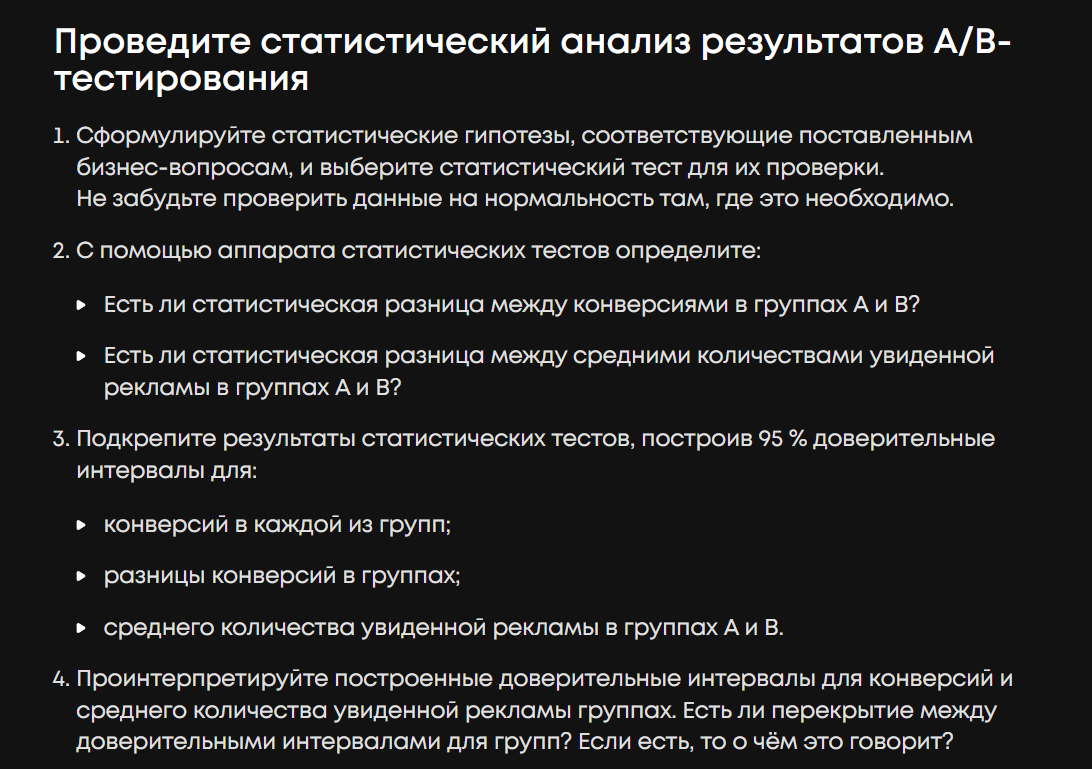

Формулировка статистических гипотиз: 
Нулевая гипотиза (H0) - предполагает, что между показателями конверсии для группами пользователей, получавших рекламу (ad) и не получавших рекламму (spa) нет разницы. Таким образом, демонстрация пользвоталям рекламы не имеет существенного эффекта на повышение продаж товара.

Альтернативной гипотезиой (H1) являетя предположение о том, что демонстрация рекламы прямо увеличивает число проджа.

Shapiro-Wilk Test: Statistic=0.4801062979273719, 
p-value=8.011010627640607e-204
Данные не распределены нормально (отвергаем H0).
Kolmogorov-Smirnov Test: Statistic=0.8809976936804118, 
p-value=0.0
Данные не распределены нормально (отвергаем H0).


C:\Users\Eve\AppData\Roaming\Python\Python312\site-packages\scipy\stats\_axis_nan_policy.py:573: UserWarning: scipy.stats.shapiro: For N > 5000, computed p-value may not be accurate. Current N is 588101.
  res = hypotest_fun_out(*samples, **kwds)


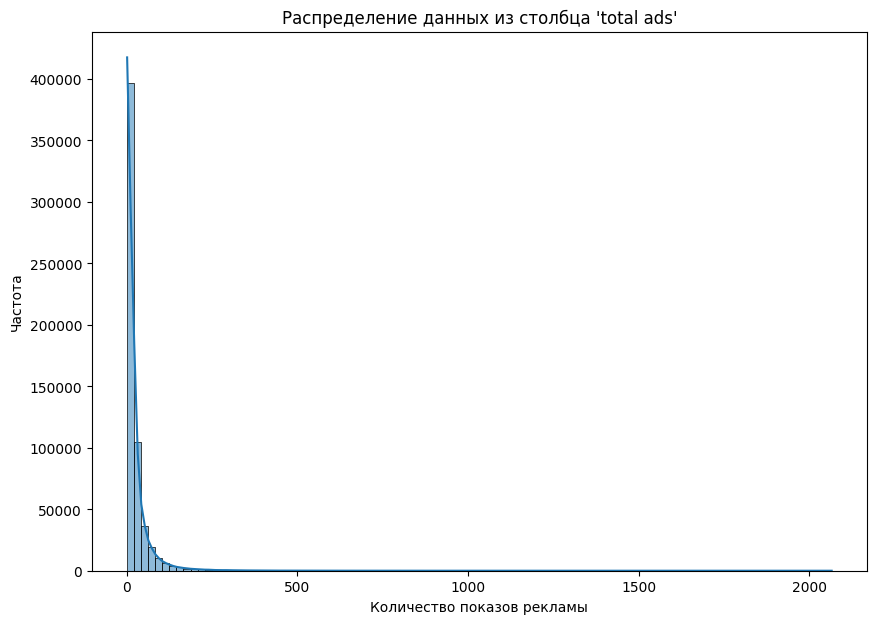

In [422]:
# Проверка статитических данных в столбцке total ads 
# на нормальность распределения 
# В качестве теста бужут использоваться тесты 
# Шапиро-Уилка и Колмогорова-Смирнова из библиотеки scipy


data_column = dataset['total ads']

# Тест Шапиро-Уилка
stat, p_value = shapiro(data_column)
print(f"Shapiro-Wilk Test: Statistic={stat}, \np-value={p_value}")
if p_value > 0.05:
    print("Данные распределены нормально (не отвергаем H0).")
else:
    print("Данные не распределены нормально (отвергаем H0).")

# Тест Колмогорова-Смирнова
stat, p_value = kstest(data_column, 'norm')
print(f"Kolmogorov-Smirnov Test: Statistic={stat}, \np-value={p_value}")
if p_value > 0.05:
    print("Данные распределены нормально (не отвергаем H0).")
else:
    print("Данные не распределены нормально (отвергаем H0).")

# Визуализация данных
plt.figure(figsize=(10, 7))
sns.histplot(data_column, kde=True, bins=100)
plt.title("Распределение данных из столбца 'total ads'")
plt.xlabel("Количество показов рекламы")
plt.ylabel("Частота")
plt.show()



По результатам тестов Шапиро-Уилка и Колмогорова-Смирнова распределение  данных в столбце total ads не является нормальным.

Так как, группы A и B сильно не сбалансированы между собой, то для проверки нулевой гипотизы следует использовать непараметрический тест Манна-Уитни.

In [423]:
# Выявление статисческой значимости конверсии  между группами
# Разделение данных на группы

ad_group = dataset[dataset['test group'] == 'ad']['converted']
psa_group = dataset[dataset['test group'] == 'psa']['converted']

# Применение Теста Манна-Уитни: 

stat, p_value = mannwhitneyu(ad_group, psa_group, alternative='greater')
print(f"Mann-Whitney U Test: Statistic={stat}, p-value={p_value}")

# Интерпретация результатов, выводы:

if p_value < 0.05:
    print("Демонстрация рекламы статистически значимо повышает конверсию (нулевая гипотиза H0 отклонена).")
else:
    print("Демонстрация рекламы не дает статистически значимого эффекта от рекламы (нулевая гипотиза H0 принята).")

Mann-Whitney U Test: Statistic=6691636830.0, p-value=8.526808965085939e-14
Демонстрация рекламы статистически значимо повышает конверсию (нулевая гипотиза H0 отклонена).


### Ответ: Выявлена статистически значимая разница между конверсиями исследуемых групп A и B.

In [424]:
# Находим среднее количестве увиденной рекламы в группе ad

# Фильтрация данных для группы 'ad'
ad_total_ads = dataset[dataset['test group'] == 'ad']['total ads']

# Расчет среднего значения количества рекламы для группы 'ad'
ad_mean_ads = ad_total_ads.mean()

# Вывод результата
print(f'Среднее количество увиденной рекламы в группе "ad": {ad_mean_ads:.2f}')


Среднее количество увиденной рекламы в группе "ad": 24.82


In [425]:
# Находим среднее количестве увиденных сообщений государственной службы 
# в группе psa

# Фильтрация данных для группы 'psa'
psa_total_ads = dataset[dataset['test group'] == 'psa']['total ads']

# Расчет среднего значения количества рекламы для группы 'psa'
psa_mean_ads = psa_total_ads.mean()

# Вывод результата
print(f'Среднее количество увиденных сообщений в группе "psa": {psa_mean_ads:.2f}')

Среднее количество увиденных сообщений в группе "psa": 24.76


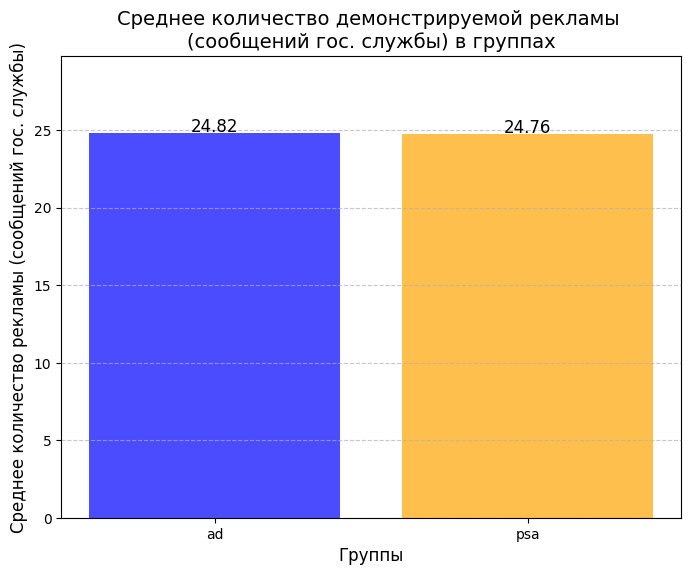

In [426]:
# Построение графика для значения среднего количества
#  рекламы (сообщений) в группах'ad' и 'psa'
groups = ['ad', 'psa']
means = [ad_mean_ads, psa_mean_ads]

# Построение графика
plt.figure(figsize=(8, 6))
plt.bar(groups, means, color=['blue', 'orange'], alpha=0.7)

# Добавление подписей
for i, mean in enumerate(means):
    plt.text(i, mean + 0.1, f'{mean:.2f}', ha='center', fontsize=12)

# Вывод графика
plt.title('Среднее количество демонстрируемой рекламы \n(сообщений гос. службы) в группах', fontsize=14)
plt.ylabel('Среднее количество рекламы (сообщений гос. службы)', fontsize=12)
plt.xlabel('Группы', fontsize=12)
plt.ylim(0, max(means) * 1.2)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

In [427]:

# Проверка наличия статистически значимой разницы между группами 
# по показателю среднего количества увиденной рекламы (сообщений гос. службы)


ad_total_ads = dataset[dataset['test group'] == 'ad']['total ads']
psa_total_ads = dataset[dataset['test group'] == 'psa']['total ads']

# Применение теста Манна-Уитни
stat, p_value = mannwhitneyu(ad_total_ads, psa_total_ads, alternative='two-sided')
print(f"Mann-Whitney U Test: Statistic={stat}, p-value={p_value}")

# Интерпретация результатов, выводы:
if p_value < 0.05:
    print("Есть статистически значимая разница между средним количеством демонстрируемых сообщений в группах")
else:
    print("Нет статистически значимой разницы между средним количеством увиденной рекламы в группах")

Mann-Whitney U Test: Statistic=6808288222.0, p-value=4.6909108547205694e-11
Есть статистически значимая разница между средним количеством демонстрируемых сообщений в группах


### Ответ: Выявлено статистическое различие между количеством демонстрируемой рекламны (для группы ad) и сообщений гос. службы (для группы spa).

In [428]:
# Построение доверительного интервала для группа 'ad' и 'psa' 
# по значению конверсии

import statsmodels.api as sm
import numpy as np

# Подсчет количества пользователей и конверсий в каждой группе

# Количество пользователей в группе 'ad'
user_group_ad_count = len(dataset[dataset['test group'] == 'ad'])
# Конверсия в группе 'ad'
ad_converted = len(dataset[(dataset['test group'] == 'ad') & (dataset['converted'] == True)])

# Количество пользователей в группе 'psa'
user_group_psa_count = len(dataset[dataset['test group'] == 'psa'])
# Конверсия в группе 'psa'
psa_converted = len(dataset[(dataset['test group'] == 'psa') & (dataset['converted'] == True)])

# Расчет доверительного интервала для группы ad, значение alфа установим 0.05 
# так как 95% доверительный интервал.
ad_conversion_rate = ad_converted / user_group_ad_count
ad_ci = sm.stats.proportion_confint(ad_converted, user_group_ad_count, alpha=0.05, method='wilson')

# Расчет доверительного интервала для группы psa, значение alфа установим 0.05 
# так как 95% доверительный интервал.
psa_conversion_rate = psa_converted / user_group_psa_count
psa_ci = sm.stats.proportion_confint(psa_converted, user_group_psa_count, alpha=0.05, method='wilson')

# Вывод результатов, выводы:
print(f"Конверсия в группе 'ad': {ad_conversion_rate:.4f}")
print(f"Доверительный интервал конверсии для группы 'ad': {ad_ci[0]:.4f} - {ad_ci[1]:.4f}")

print(f"Конверсия в группе 'psa': {psa_conversion_rate:.4f}")
print(f"Доверительный интервал конверсии для группы 'psa': {psa_ci[0]:.4f} - {psa_ci[1]:.4f}")

Конверсия в группе 'ad': 0.0255
Доверительный интервал конверсии для группы 'ad': 0.0251 - 0.0260
Конверсия в группе 'psa': 0.0179
Доверительный интервал конверсии для группы 'psa': 0.0162 - 0.0196


In [429]:
# Рассчет 95% интервала для разницы конверсий между группами 'ad' и 'psa'
# Для расчета использованы значения ad_conversion_rate и psa_conversion_rate, 
# вычтсленные вырше.

# Разница конверсий
conversion_diff = ad_conversion_rate - psa_conversion_rate

# Стандартная ошибка разницы
se_diff = np.sqrt((ad_conversion_rate * (1 - ad_conversion_rate) / user_group_ad_count) +
                  (psa_conversion_rate * (1 - psa_conversion_rate) / user_group_psa_count))

# Построение доверительного интервала
# Так как, строится доверительный интервал в 95%, то значение 
# z используется в значении 1.96 
z = 1.96  
lower = conversion_diff - z * se_diff
upper = conversion_diff + z * se_diff

# Вывод результатов
print(f"Разница конверсий: {conversion_diff:.4f}")
print(f"95% доверительный интервал для разницы конверсий: ({lower:.4f}, {upper:.4f})")

Разница конверсий: 0.0077
95% доверительный интервал для разницы конверсий: (0.0060, 0.0094)


### Ответ 
Разница конверсий между двумя группама составляет 0.0077
Границы доверительного интервала 95% составлет 0.0060 (нижняя граница) 
0.0094 (верхняя граница).

In [430]:
# Вычисление доверительного интервала в 95% 
# Данные среднего значения просмотра рекламы для группы 'ad'
ad_mean = np.mean(ad_total_ads)
ad_std_error = np.std(ad_total_ads, ddof=1) / np.sqrt(len(ad_total_ads))  # Стандартная ошибка среднего
z = norm.ppf(0.975)  # z-значение для 95% доверительного интервала
ad_lower_border = ad_mean - z * ad_std_error
ad_upper_border = ad_mean + z * ad_std_error

# Вычисление доверительного интервала в 95% 
# Данные среднего значения просмотра сообщений для группы 'psa'
psa_mean = np.mean(psa_total_ads)
psa_std_error = np.std(psa_total_ads, ddof=1) / np.sqrt(len(psa_total_ads))  # Стандартная ошибка среднего
psa_lower_border = psa_mean - z * psa_std_error
psa_upper_border = psa_mean + z * psa_std_error

# Вывод результатов
print(f"Среднее количество рекламы в группе 'ad': {ad_mean:.2f}")
print(f"95% доверительный интервал для среднего значения рекламы группы 'ad': ({ad_lower_border:.2f}, {ad_upper_border:.2f})")

print(f"Среднее количество рекламы для среднего значения сообщений в группе 'psa': {psa_mean:.2f}")
print(f"95% доверительный интервал для группы 'psa': ({psa_lower_border:.2f}, {psa_upper_border:.2f})")

Среднее количество рекламы в группе 'ad': 24.82
95% доверительный интервал для среднего значения рекламы группы 'ad': (24.71, 24.94)
Среднее количество рекламы для среднего значения сообщений в группе 'psa': 24.76
95% доверительный интервал для группы 'psa': (24.21, 25.31)


### Интерпретация полученных данных 


Проинтерпретируйте построенные доверительные интервалы для конверсий и среднего количества увиденной рекламы группах. Есть ли перекрытие между доверительными интервалами для групп? Если есть, то о чём это говорит?

1. Ранее были получены результаты, согласно которым конверсия составила для группы ad - 0.0255 (т.е. 2,55%), для группы psa - 0.0179 (т.е. 1,79%)

Доверительный интервал (95%) конверсии для группы ad находится в пределах :
0.0251 - 0.0260, аналогичный доверительный интервал для группы psa: 
0.0162 - 0.0196.

Очевидно, что полученные доверительные интервалы не пересекаются между собой, что говорит о наличии статистической значимости между конверсиями исследованных групп. То есть, можно сделать вывод о том, что демонстарция рекламы повышает число продажи на сайте.

2. Полученный доверительный интервал (95%) для среднего значения показа рекламы в группе "ad" - (24.71 - 24.94), при среднем количестве демонстрации рекламы для названной группы -  24.82.
Аналогичный доверитеььный интервал (95%) для среднего значения демострации сообщений государственной службы группы "psa" - (24.21, 25.31), при среднем количестве демонстрации сообщений государственной службы для группы "psa" - 24.76.

Учитывая, что полученные доверительные интервылы не пересекаются, можно сделать вывод о том, что между указанными показателями имеется статистически значимые различия. 

### Вывод: Демонстрация рекламы повышает конверсию (число продаж товара).

Примечание: Рекомендовано повторить указанный тест при повышении объема тестовой выборки, хотяб в размере 20% процентов от эксперементальной.

